In [1]:
import sys
import os

# Projektverzeichnis
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Füge dem sys.path hinzu, falls noch nicht vorhanden
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# Datenzugriff
from configs.path_manager import get_path
from models import *

# Utils
import src.utils.presenter as show
from src.utils.production_process import convert
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

from src.utils.production_process import time_determination as term
from src.utils.production_process import gen_deadline as gen_deadline
from src.utils.production_process import filter as process_filter

# Solver Model
from src.models.cp import lateness_scheduling as cp_late_schedule
from src.models.cp import lateness_rescheduling as cp_late_reschedule
import src.models.heuristics.fcfs as fcfs


# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Extern
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 21)

In [3]:
max_time = 60 * 15 # 15 min

In [4]:
Job.clone_jobs(referenced_version="base", new_version="lateness_plus")
JSSP_LIVE.clone_operations(referenced_version="base", new_version="lateness_plus")

✅ 7250 Jobs von Version 'base' nach Version 'lateness_plus' kopiert.
✅ 0 JSSP_LIVE-Einträge von Version 'base' nach Version 'lateness_plus' kopiert.


## Laden des fertigen Datensatzes (3 Tage Ankunft)

In [5]:
# Jobs
df_jobs_times = Job.get_dataframe(version="lateness_plus")
df_jobs_times = df_jobs_times[df_jobs_times.Arrival <= 60*24*3]
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,Deadline,Status,Version
0,J25-0000,8,79,1440,3660,open,lateness_plus
1,J25-0001,6,129,1440,2338,open,lateness_plus
2,J25-0002,0,198,1440,3744,open,lateness_plus
3,J25-0003,2,243,1440,3379,open,lateness_plus
4,J25-0004,3,287,1440,4856,open,lateness_plus
...,...,...,...,...,...,...,...
59,J25-0059,1,4076,4320,6187,open,lateness_plus
60,J25-0060,1,4147,4320,5633,open,lateness_plus
61,J25-0061,9,4233,4320,6533,open,lateness_plus
62,J25-0062,6,4259,4320,6091,open,lateness_plus


In [6]:
# Routings
df_routings = RoutingOperation.get_dataframe()
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
...,...,...,...,...
95,9,5,M09,76
96,9,6,M05,47
97,9,7,M03,52
98,9,8,M04,90


In [7]:
def get_jssp_for_jobs(df_jobs_times, df_routings):
    """
    Erstellt ein JSSP-kompatibles DataFrame durch Verknüpfung von Job-Zeitdaten mit Routings.

    Parameter:
    - df_jobs_times: DataFrame mit mindestens den Spalten 'Job' und 'Routing_ID'.
    - df_routings: DataFrame mit Spalte 'Routing_ID' und den zugehörigen Operationsdaten.

    Rückgabe:
    - df_jssp: DataFrame mit allen für das JSSP notwendigen Informationen, inklusive 'Job' und den Operationen.
    """
    # 1. Relevante Spalten extrahieren
    df_job_ids = df_jobs_times[['Job', 'Routing_ID']].copy()

    # 2. Merge mit df_routings über Routing_ID
    df_jssp = df_job_ids.merge(df_routings, on='Routing_ID')

    return df_jssp

In [8]:
df_jssp = get_jssp_for_jobs(df_jobs_times, df_routings)
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
...,...,...,...,...,...
635,J25-0063,3,5,M08,52
636,J25-0063,3,6,M07,85
637,J25-0063,3,7,M03,98
638,J25-0063,3,8,M09,22


In [9]:
JSSP_LIVE.add_from_dataframe(df_jssp, version="lateness_plus", status="open")

✅ 640 JSSP_LIVE-Einträge (Version 'lateness_plus', Status 'open') wurden hinzugefügt oder aktualisiert.


### Params

In [10]:
day_length = 1440
day_numb = 0
day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 00: [0, 1440)


## Tag 1 (init. Tag - kein Rescheduling)

In [11]:
day_numb = 1

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [12]:
# alle aktuelle "offenen" Jobs
df_job_times_curr = Job.get_dataframe(version="lateness_plus", arrival_time_max=day_start, status="open")
df_job_times_curr

,Job,Routing_ID,Arrival,Ready Time,Deadline,Status,Version
0,J25-0000,8,79,1440,3660,open,lateness_plus
1,J25-0001,6,129,1440,2338,open,lateness_plus
2,J25-0002,0,198,1440,3744,open,lateness_plus
3,J25-0003,2,243,1440,3379,open,lateness_plus
4,J25-0004,3,287,1440,4856,open,lateness_plus
5,J25-0005,1,498,1440,3106,open,lateness_plus
6,J25-0006,9,790,1440,3539,open,lateness_plus
7,J25-0007,5,925,1440,2929,open,lateness_plus
8,J25-0008,4,988,1440,3541,open,lateness_plus
9,J25-0009,7,1004,1440,3578,open,lateness_plus


In [13]:
#  JSSP zu allen "offenen" Jobs
df_jssp_temp = get_jssp_for_jobs(df_job_times_curr, df_routings)
df_jssp_temp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
...,...,...,...,...,...
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47
157,J25-0015,5,7,M06,65
158,J25-0015,5,8,M04,6


In [14]:
#  JSSP zu allen "offenen" Jobs, mit "offenen" Operationen
df_jobs_ops = JSSP_LIVE.get_dataframe(version="lateness_plus", jobs=df_jssp_temp.Job.tolist(), status="open")
df_jssp_curr = df_jssp_temp.merge(df_jobs_ops[['Job', 'Operation']], on=['Job', 'Operation'], how='inner')
df_jssp_curr

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
...,...,...,...,...,...
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47
157,J25-0015,5,7,M06,65
158,J25-0015,5,8,M04,6


### A) Scheduling

In [15]:
# Scheduling
df_schedule = cp_late_schedule.solve_jssp_sum_by_tardiness_and_earliness(df_jssp_curr, df_job_times_curr, 
                                                                         schedule_start = day_start, w_t=5,
                                                                         msg=False, timeLimit=max_time)
df_schedule 


Solver-Status         : OPTIMAL
Objective Value       : 0.00
Best Objective Bound  : 0.00
Laufzeit              : 0.04 Sekunden


,Job,Routing_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,J25-0005,1,0,M00,498,3106,1440,43,1483,-1623,0,1623
1,J25-0007,5,0,M02,925,2929,1440,84,1524,-1405,0,1405
2,J25-0013,3,0,M01,1192,2567,1440,81,1521,-1046,0,1046
3,J25-0011,1,0,M00,1030,3210,1483,43,1526,-1684,0,1684
4,J25-0001,6,0,M01,129,2338,1521,46,1567,-771,0,771
...,...,...,...,...,...,...,...,...,...,...,...,...
155,J25-0009,7,9,M03,1004,3578,3499,79,3578,0,0,0
156,J25-0000,8,9,M08,79,3660,3586,74,3660,0,0,0
157,J25-0002,0,9,M09,198,3744,3723,21,3744,0,0,0
158,J25-0012,2,9,M04,1103,4385,4352,33,4385,0,0,0


In [16]:
json_schedule = df_schedule.to_dict(orient='records')

Schedule.add_schedule(
    data=json_schedule,
    date=day_numb,
    version="lateness_plus"
)

✅ Schedule hinzugefügt (Version=lateness_plus, Date=1)


### B) Simulation

In [17]:
simulation = ProductionSimulation(df_schedule, sigma=0.2)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J25-0005 started on M00
[Day 1 00:00:00] Job J25-0007 started on M02
[Day 1 00:00:00] Job J25-0013 started on M01
[Day 1 00:28:26] Job J25-0005 finished on M00 (after 28 minutes 26 seconds)
[Day 1 00:43:00] Job J25-0011 started on M00
[Day 1 01:13:22] Job J25-0011 finished on M00 (after 30 minutes 23 seconds)
[Day 1 01:26:00] Job J25-0010 started on M00
[Day 1 01:27:13] Job J25-0013 finished on M01 (after 87 minutes 13 seconds)
[Day 1 01:27:13] Job J25-0001 started on M01
[Day 1 01:49:18] Job J25-0007 finished on M02 (after 109 minutes 19 seconds)
[Day 1 01:49:18] Job J25-0013 started on M02
[Day 1 02:02:39] Job J25-0010 finished on M00 (after 36 minutes 40 seconds)
[Day 1 02:02:39] Job J25-0000 started on M00
[Day 1 02:03:38] Job J25-0001 finished on M01 (after 36 minutes 25 seconds)
[Day 1 02:07:00] Job J25-0007 started on M01
[Day 1 02:08:47] Job J25-0007 finished on M01 (after 01 minute 48 seconds)
[Day 1 02:09:00] Job J25-0003 started on M01
[Day 1 02:09:00] J

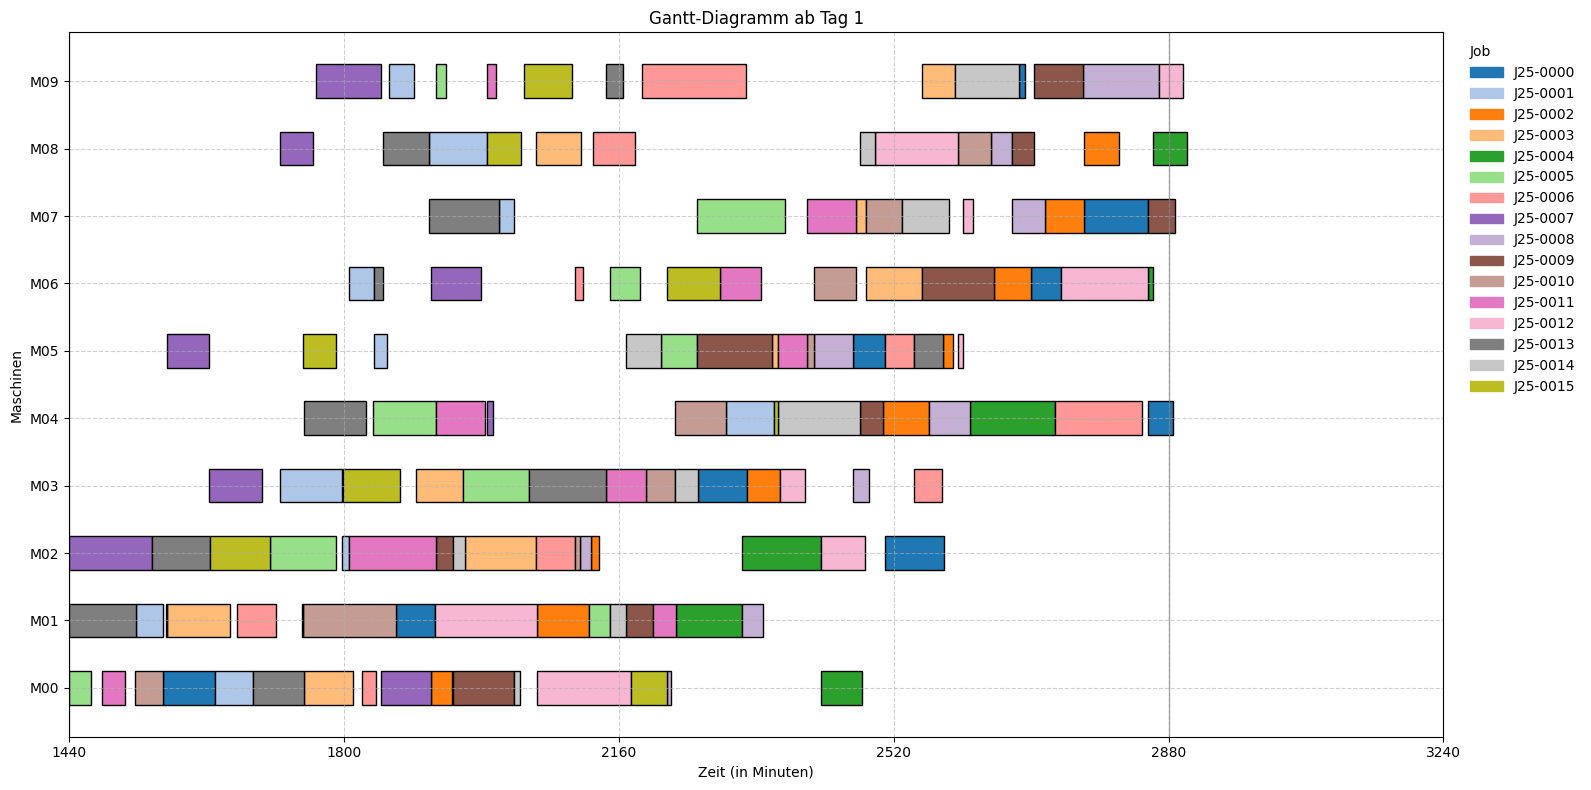

In [18]:
show.plot_gantt(df_execution, perspective="Machine", title=f"Gantt-Diagramm ab Tag {day_numb}")

In [19]:
df_ops_finished = df_execution[df_execution.End < day_end]
JSSP_LIVE.add_from_dataframe(df_ops_finished, version="lateness_plus", status="finished")
df_ops_finished

✅ 139 JSSP_LIVE-Einträge (Version 'lateness_plus', Status 'finished') wurden hinzugefügt oder aktualisiert.


,Job,Routing_ID,Operation,Machine,Arrival,Start,Processing Time,End
0,J25-0000,8,0,M00,79,1562.66,68.73,1631.39
1,J25-0000,8,1,M01,79,1868.78,50.79,1919.57
2,J25-0000,8,2,M03,79,2264.13,64.42,2328.55
3,J25-0000,8,3,M05,79,2466.17,43.16,2509.33
4,J25-0000,8,4,M02,79,2509.33,75.98,2585.31
...,...,...,...,...,...,...,...,...
138,J25-0015,5,4,M08,1436,1988.00,44.01,2032.01
139,J25-0015,5,5,M09,1436,2036.00,63.38,2099.38
140,J25-0015,5,6,M00,1436,2176.54,46.70,2223.24
141,J25-0015,5,7,M06,1436,2223.24,68.93,2292.17


In [20]:
JSSP_LIVE.update_closed_jobs_from_operations(version="lateness_plus")

✅ 2 Job(s) wurden auf 'closed' gesetzt (Version 'lateness_plus').


['J25-0001', 'J25-0013']

In [21]:
df_ops_in_progess = df_execution[df_execution.End >= day_end]
JSSP_LIVE.add_from_dataframe(df_ops_in_progess, version="lateness_plus", status="in progress")
df_ops_in_progess

✅ 4 JSSP_LIVE-Einträge (Version 'lateness_plus', Status 'in progress') wurden hinzugefügt oder aktualisiert.


,Job,Routing_ID,Operation,Machine,Arrival,Start,Processing Time,End
8,J25-0000,8,8,M04,79,2853.03,32.33,2885.36
42,J25-0004,3,5,M08,287,2859.74,44.35,2904.09
87,J25-0009,7,8,M07,1004,2853.03,34.89,2887.92
114,J25-0012,2,8,M09,1103,2867.89,31.42,2899.31


## II) Tag 2

In [22]:
this_version = "lateness_plus"

In [23]:
day_numb = 2

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [24]:
# alle aktuelle "offenen" Jobs
df_jobs_times_curr = Job.get_dataframe(version=this_version, arrival_time_max=day_start, status="open")
df_jobs_times_curr

,Job,Routing_ID,Arrival,Ready Time,Deadline,Status,Version
0,J25-0000,8,79,1440,3660,open,lateness_plus
1,J25-0002,0,198,1440,3744,open,lateness_plus
2,J25-0003,2,243,1440,3379,open,lateness_plus
3,J25-0004,3,287,1440,4856,open,lateness_plus
4,J25-0005,1,498,1440,3106,open,lateness_plus
...,...,...,...,...,...,...,...
31,J25-0033,2,2660,2880,6738,open,lateness_plus
32,J25-0034,8,2715,2880,6387,open,lateness_plus
33,J25-0035,5,2726,2880,4126,open,lateness_plus
34,J25-0036,4,2734,2880,5231,open,lateness_plus


In [25]:
#  JSSP zu allen "offenen" Jobs (auch fertige Operationen)
df_jssp_temp = get_jssp_for_jobs(df_jobs_times_curr, df_routings)


#  JSSP zu allen "offenen" Jobs, mit "offenen" Operationen
df_jobs_ops = JSSP_LIVE.get_dataframe(version=this_version, jobs=df_jssp_temp.Job.tolist(), status="open")
df_jssp_curr = df_jssp_temp.merge(df_jobs_ops[['Job', 'Operation']], on=['Job', 'Operation'], how='inner')
df_jssp_curr

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,9,M08,74
1,J25-0002,0,9,M09,21
2,J25-0003,2,9,M04,33
3,J25-0004,3,6,M07,85
4,J25-0004,3,7,M03,98
...,...,...,...,...,...
232,J25-0037,7,5,M06,88
233,J25-0037,7,6,M08,19
234,J25-0037,7,7,M09,48
235,J25-0037,7,8,M07,36


In [26]:
# Relevante 
df_ops_in_progess = JSSP_LIVE.get_dataframe(version=this_version, status="in progress")
df_ops_in_progess

,Job,Routing_ID,Machine,Operation,Start,End,Processing Time,Version,Operation Status
0,J25-0000,8,M04,8,2853.03,2885.36,32.33,lateness_plus,in progress
1,J25-0004,3,M08,5,2859.74,2904.09,44.35,lateness_plus,in progress
2,J25-0009,7,M07,8,2853.03,2887.92,34.89,lateness_plus,in progress
3,J25-0012,2,M09,8,2867.89,2899.31,31.42,lateness_plus,in progress


In [27]:
## Hole den vorherigen Schedule
df_schedule = Schedule.get_schedule_as_dataframe(date=day_numb-1, version=this_version)

# Hole die offenen Operationen für die enthaltenen Jobs
df_open_ops = JSSP_LIVE.get_dataframe(version=this_version, jobs=df_schedule["Job"].unique().tolist(), status="open")

# Mache ein Inner Join auf ["Job", "Operation"]
df_schedule_prev = df_schedule.merge(df_open_ops[["Job", "Operation"]], on=["Job", "Operation"], how="inner")
df_schedule_prev

ℹ️ Achtung: 2 Schedules gefunden – letzter Eintrag (ID 11) wird verwendet.


,Job,Routing_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,J25-0007,5,9,M07,925,2929,2904,25,2929,0,0,0
1,J25-0015,5,9,M07,1436,2981,2956,25,2981,0,0,0
2,J25-0004,3,6,M07,287,4856,2981,85,3066,-1790,0,1790
3,J25-0004,3,7,M03,287,4856,3066,98,3164,-1692,0,1692
4,J25-0005,1,9,M08,498,3106,3076,30,3106,0,0,0
5,J25-0004,3,8,M09,287,4856,3164,22,3186,-1670,0,1670
6,J25-0011,1,9,M08,1030,3210,3180,30,3210,0,0,0
7,J25-0014,4,9,M06,1222,3315,3262,53,3315,0,0,0
8,J25-0010,0,9,M09,1025,3345,3324,21,3345,0,0,0
9,J25-0003,2,9,M04,243,3379,3346,33,3379,0,0,0


### Rescheduling

#### Old Version

$$
min   Z = r \cdot \sum_{j \in \text{Jobs}} \left( w_t \cdot \text{Tardiness}_j + w_e \cdot \text{Earliness}_j \right) + (1 - r) \cdot \sum_{(j,o) \in \text{DevOps}} \left| \text{Start}_{j,o} - \text{Start}_{j,o}^{\text{original}} \right|
$$



Solver-Status         : OPTIMAL
Objective Value       : 1260.00
Best Objective Bound  : 1260.00
Laufzeit              : 0.20 Sekunden
Deviation terms       : 17


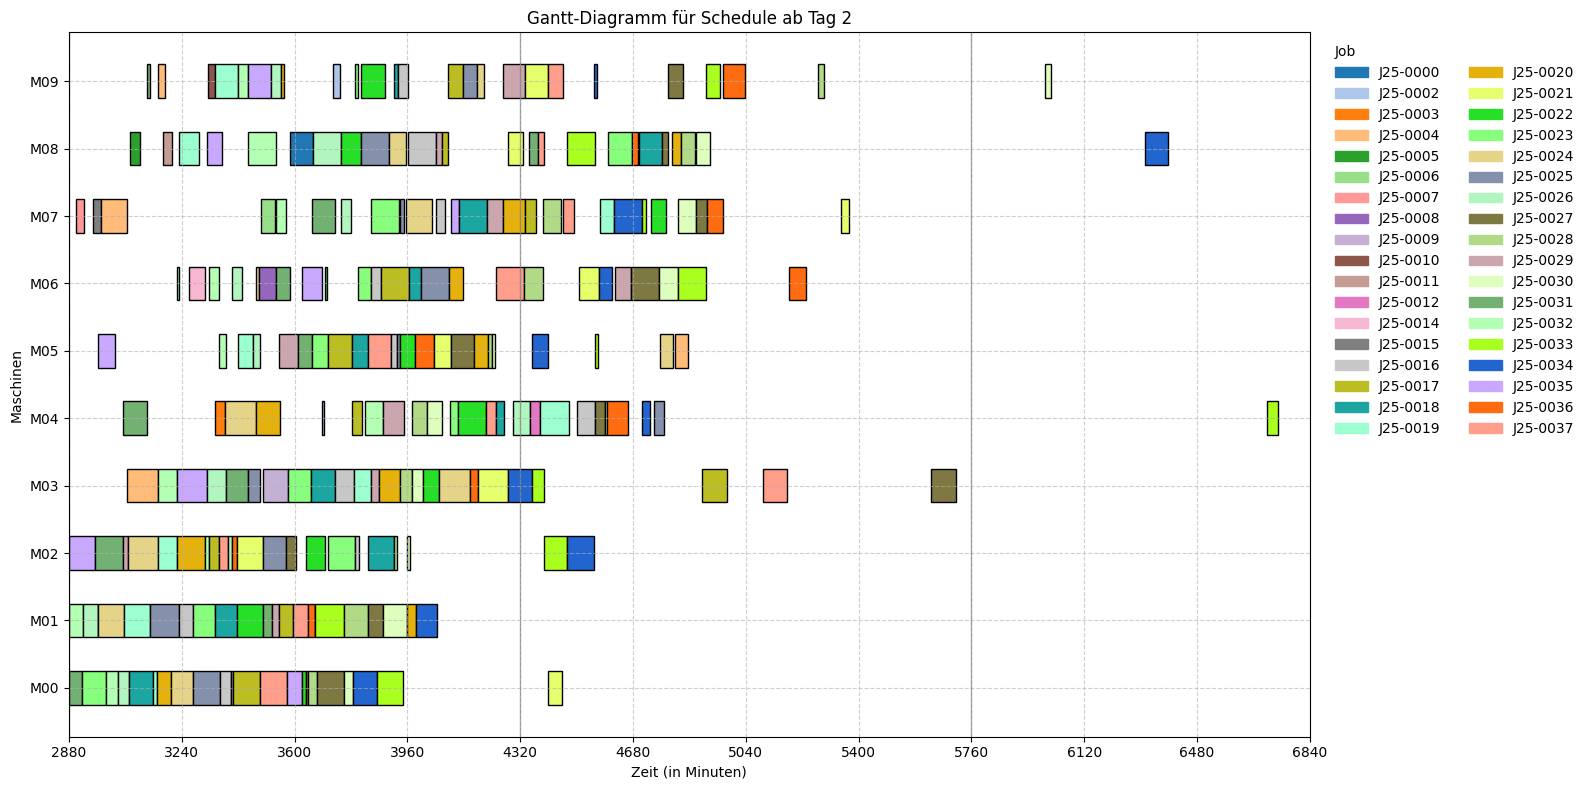

In [28]:
df_schedule = cp_late_reschedule.solve_jssp_by_tardiness_and_earliness_with_devpen(df_jssp_curr, df_jobs_times_curr, 
                                                                                   df_ops_in_progess, 
                                                                                   df_original_plan = df_schedule_prev,
                                                                                   w_t = 5,
                                                                                   r = 0.2, # 20% Lateness, 80% Deviation
                                                                                   reschedule_start = day_start, 
                                                                                   msg=False, timeLimit=max_time, gapRel= 0.001)

show.plot_gantt(df_schedule, perspective="Machine", title=f"Gantt-Diagramm für Schedule ab Tag {day_numb}")

$$
Z = \alpha \cdot \left[
r \cdot \sum_{j \in \text{Jobs}} \left( w_t \cdot \max(0, C_j - D_j) + w_e \cdot \max(0, D_j - C_j) \right)
+ (1 - r) \cdot \sum_{(j,o) \in \text{DevOps}} \left| S_{j,o} - S_{j,o}^{\text{orig}} \right|
\right]
- (1 - \alpha) \cdot \sum_{j \in \text{Jobs}} S_j^{\text{first}}
$$


In [29]:
import math
from ortools.sat.python import cp_model
import pandas as pd

In [30]:
def solve_jssp_advanced(df_jssp: pd.DataFrame, df_times: pd.DataFrame, 
                                                                  df_executed: pd.DataFrame, df_original_plan: pd.DataFrame, job_column: str = "Job",
                                                                  w_t: int = 5, w_e: int = 1, r: float = 0.5, 
                                                                  reschedule_start: float = 1440.0, sort_ascending: bool = False,
                                                                  msg: bool = False, timeLimit: int = 3600, gapRel: float = 0.0,
                                                                  alpha: float = 1.0) -> pd.DataFrame:
    # 1. === Modell erstellen ===
    model = cp_model.CpModel()
    w_t = int(w_t)
    w_e = int(w_e)
    r_scaled = int(round(r * 100))
    alpha_scaled = int(round(alpha * 100))

    # 2. === Vorverarbeitung: Ankunft, Deadline, Jobs ===
    df_times = df_times.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_times.set_index(job_column)["Arrival"].to_dict()
    deadline = df_times.set_index(job_column)["Deadline"].to_dict()
    jobs = df_times[job_column].tolist()

    # 3. === Schnittmenge von Operationen für Deviation bestimmen ===
    deviation_ops = set(df_jssp[[job_column, "Operation"]].apply(tuple, axis=1)) & \
                    set(df_original_plan[[job_column, "Operation"]].apply(tuple, axis=1))
    original_start = {
        (row[job_column], row["Operation"]): int(round(row["Start"]))
        for _, row in df_original_plan.iterrows()
        if (row[job_column], row["Operation"]) in deviation_ops
    }

    # 4. === Operationen gruppieren, Maschinen erfassen ===
    ops_grouped = df_jssp.sort_values([job_column, "Operation"]).groupby(job_column)
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    # 5. === Planungshorizont schätzen ===
    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    # 6. === Fixierte Operationen vorbereiten ===
    df_executed_fixed = df_executed[df_executed["End"] >= reschedule_start]
    fixed_ops = {
        m: list(grp[["Start", "End"]].itertuples(index=False, name=None))
        for m, grp in df_executed_fixed.groupby("Machine")
    }
    last_executed_end = df_executed.groupby(job_column)["End"].max().to_dict()

    # 7. === Variablen definieren ===
    starts, ends, intervals = {}, {}, {}
    weighted_terms = []
    deviation_terms = []

    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # 8. === Nebenbedingungen und Zielterme ===
    for j, job in enumerate(jobs):
        last_op = len(all_ops[j]) - 1
        job_end = ends[(j, last_op)]

        # Lateness, Tardiness, Earliness
        lateness = model.NewIntVar(-horizon, horizon, f"lateness_{j}")
        model.Add(lateness == job_end - deadline[job])

        tardiness = model.NewIntVar(0, horizon, f"tardiness_{j}")
        model.AddMaxEquality(tardiness, [lateness, 0])
        term_t = model.NewIntVar(0, horizon * w_t, f"term_t_{j}")
        model.Add(term_t == w_t * tardiness)
        weighted_terms.append(term_t)

        earliness = model.NewIntVar(0, horizon, f"earliness_{j}")
        model.AddMaxEquality(earliness, [-lateness, 0])
        term_e = model.NewIntVar(0, horizon * w_e, f"term_e_{j}")
        model.Add(term_e == w_e * earliness)
        weighted_terms.append(term_e)

        # Startzeitbedingungen
        model.Add(starts[(j, 0)] >= max(arrival[job], int(reschedule_start)))
        if job in last_executed_end:
            model.Add(starts[(j, 0)] >= int(math.ceil(last_executed_end[job])))

        # Technologische Reihenfolge
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])

        # Deviation
        for o, (op_id, _, _) in enumerate(all_ops[j]):
            key = (job, op_id)
            if key in original_start:
                diff = model.NewIntVar(-horizon, horizon, f"diff_{j}_{o}")
                dev = model.NewIntVar(0, horizon, f"dev_{j}_{o}")
                model.Add(diff == starts[(j, o)] - original_start[key])
                model.AddAbsEquality(dev, diff)
                deviation_terms.append(dev)

    # 9. === Maschinenrestriktionen ===
    for m in machines:
        machine_intervals = [interval for (j, o), (interval, mach) in intervals.items() if mach == m]
        for fixed_start, fixed_end in fixed_ops.get(m, []):
            start = math.floor(fixed_start)
            end = math.ceil(fixed_end)
            if end > start:
                duration = end - start
                fixed_interval = model.NewIntervalVar(start, duration, end, f"fixed_{m}_{end}")
                machine_intervals.append(fixed_interval)
        model.AddNoOverlap(machine_intervals)

    # 10. === Zielfunktion zusammensetzen ===
    weighted_part = model.NewIntVar(0, horizon * len(weighted_terms), "weighted_part")
    deviation_part = model.NewIntVar(0, horizon * len(deviation_terms), "deviation_part")
    model.Add(weighted_part == sum(weighted_terms))
    model.Add(deviation_part == sum(deviation_terms))

    first_op_starts = [starts[(j, 0)] for j in range(len(jobs))]
    startsum = model.NewIntVar(0, horizon * len(jobs), "startsum")
    model.Add(startsum == sum(first_op_starts))

    start_scaled = model.NewIntVar(0, horizon * len(jobs) * 100, "start_scaled")
    model.Add(start_scaled == (100 - alpha_scaled) * startsum)

    cost_main = model.NewIntVar(0, horizon * len(jobs) * 100, "cost_main")
    model.Add(cost_main == alpha_scaled * (r_scaled * weighted_part + (100 - r_scaled) * deviation_part))

    total_cost = model.NewIntVar(0, horizon * len(jobs) * 10000, "total_cost")
    model.Add(total_cost == cost_main - start_scaled)
    model.Minimize(total_cost)

    # === Solver starten ===
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.max_time_in_seconds = timeLimit
    solver.parameters.relative_gap_limit = gapRel
    status = solver.Solve(model)

    # === Lösung extrahieren ===
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        records = get_records_from_cp(
            jobs=jobs,
            all_ops=all_ops,
            starts=starts,
            arrival=arrival,
            deadline=deadline,
            solver=solver,
            job_column=job_column,
            df_times=df_times
        )
        df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", job_column, "Operation"]).reset_index(drop=True)
    else:
        print("\nSolver-Status         :", solver.StatusName(status))
        print("No feasible solution found!")
        df_schedule = pd.DataFrame()

    # === Logging ===
    print(f"\nSolver-Status         : {solver.StatusName(status)}")
    print(f"Objective Value       : {solver.ObjectiveValue():.2f}")
    print(f"Best Objective Bound  : {solver.BestObjectiveBound():.2f}")
    print(f"Laufzeit              : {solver.WallTime():.2f} Sekunden")
    print(f"Deviation terms       : {len(deviation_terms)}")

    return df_schedule


In [31]:
def get_records_from_cp(jobs, all_ops, starts, arrival, deadline, solver, job_column="Job", df_times=None):
    """
    Erstellt Scheduling-Records mit Tardiness- und Earliness-Berechnung aus CP-Solver-Ergebnissen.

    Parameter:
    - jobs: Liste der Job-IDs.
    - all_ops: Liste der Operationen je Job [(op_id, machine, duration), ...].
    - starts: Dict mit CP-Startvariablen (solver.Value(var)).
    - arrival: Dict {Job → Arrival}.
    - deadline: Dict {Job → Deadline}.
    - solver: cp_model.CpSolver().
    - job_column: Name der Jobspalte im DataFrame.
    - df_times: Optionaler DataFrame mit 'Production_Plan_ID' je Job.

    Rückgabe:
    - Liste von Dicts mit allen Scheduling-Informationen pro Operation.
    """

    # 1. Optionales Mapping: Job → Production_Plan_ID
    if df_times is not None and "Routing_ID" in df_times.columns:
        job_routing = df_times.set_index(job_column)["Routing_ID"].to_dict()
    else:
        job_routing = {}

    # 2. Records erzeugen
    records = []
    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            st = solver.Value(starts[(j, o)])
            ed = st + d
            lateness = ed - deadline[job]

            record = {
                job_column: job,
            }
            if job in job_routing:
                record["Routing_ID"] = job_routing[job]
            record.update({
                "Operation": op_id,
                "Machine": m,
                "Arrival": arrival[job],
                "Deadline": deadline[job],
                "Start": st,
                "Processing Time": d,
                "End": ed,
                "Lateness": lateness,
                "Tardiness": max(0, lateness),
                "Earliness": max(0, -lateness)
            })
            records.append(record)

    return records


Solver-Status         : OPTIMAL
Objective Value       : 0.00
Best Objective Bound  : 0.00
Laufzeit              : 3.64 Sekunden
Deviation terms       : 17


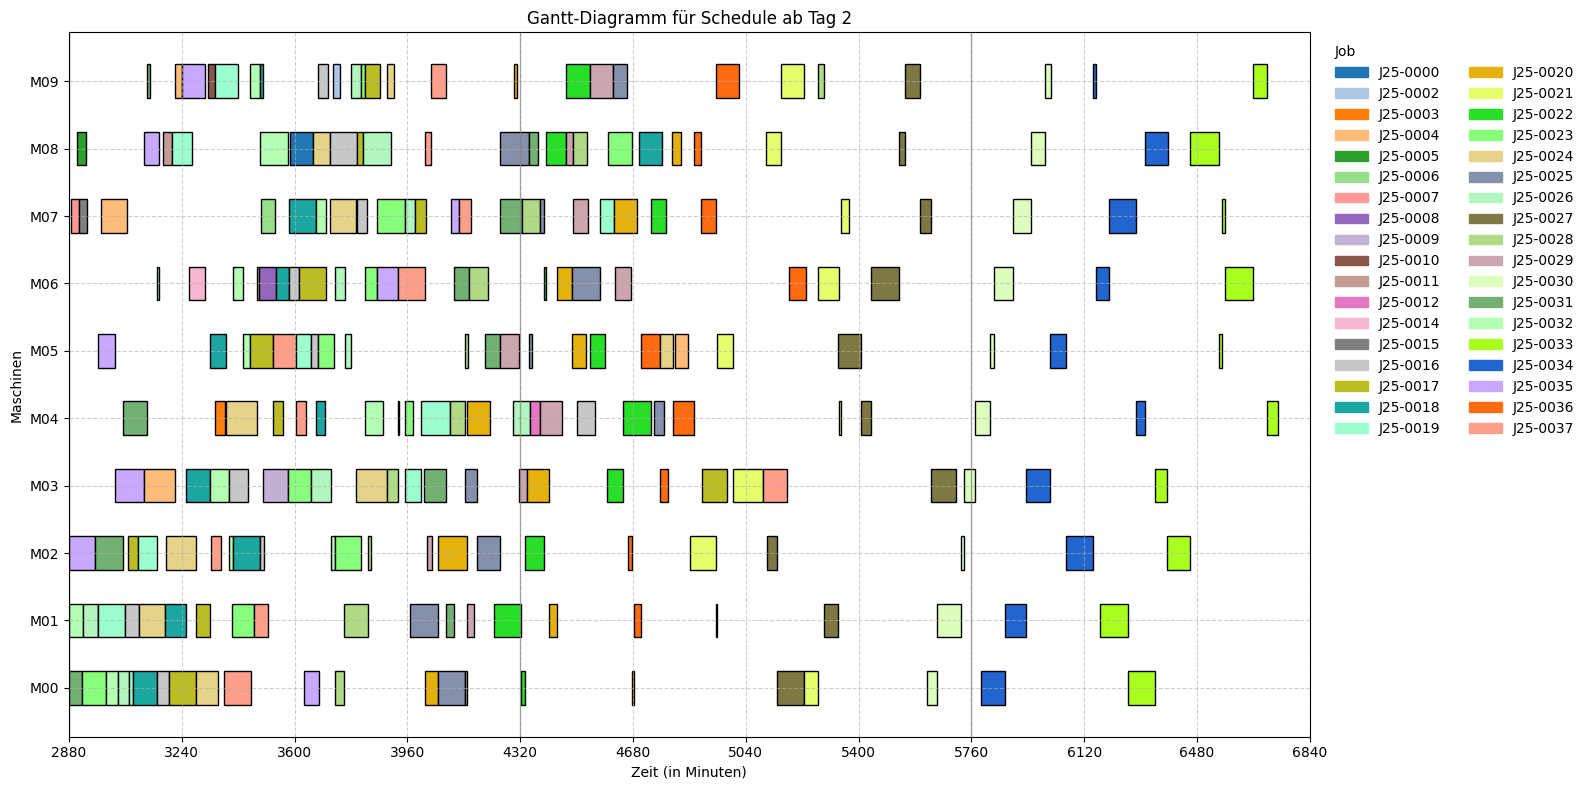

In [32]:
df_schedule = solve_jssp_advanced(df_jssp_curr, df_jobs_times_curr,  df_ops_in_progess, 
                                  df_original_plan = df_schedule_prev, w_t = 5,
                                   r = 0.2, # 20% Lateness, 80% Deviation
                                   reschedule_start = day_start, 
                                   msg=False, timeLimit=max_time, gapRel= 0.001,
                                  alpha =0.8)

show.plot_gantt(df_schedule, perspective="Machine", title=f"Gantt-Diagramm für Schedule ab Tag {day_numb}")